# Model Priors
In this notebook I will compare the different model priors that are imposed on inferred physical properties: ${\rm SSFR}$ and $Z_{\rm MW}$. The models we will compare are: 
- $\tau$ model
- delayed $\tau$ model
- 4 NMF SFH basis 
- compressed 4 NMF SFH basis

In [1]:
import numpy as np 
from provabgs import infer as Infer
from provabgs import models as Models
from astropy.cosmology import Planck13

In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
np.random.seed(0)

In [4]:
def prior_tau(tage): 
    '''model priors for tau and delayed-tau models depend on the age.
    We set the fraction of mass from constant SFH to 0 and from bursts
    to 0 (i.e. I use the simple dust model)
    '''
    prior = Infer.load_priors([
        Infer.UniformPrior(0., 0.), 
        Infer.UniformPrior(0.3, 1e1), # tau SFH
        Infer.UniformPrior(0., 0.), # constant SFH
        Infer.UniformPrior(0., tage-1.), # start time
        Infer.UniformPrior(0., 0.),  # fburst
        Infer.UniformPrior(0., tage),  # tburst
        Infer.UniformPrior(1e-4, 1e1), # metallicity
        Infer.UniformPrior(0., 4.)
    ])
    return prior

In [5]:
def prior_nmf(tage): 
    return Infer.load_priors([
        Infer.UniformPrior(0, 0, label='sed'),     # uniform priors on logM*
        Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
        Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
        Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
        Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
        Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
        Infer.UniformPrior(-2.2, 0.4, label='sed')     # uniform priors on dust_index 
    ])

In [6]:
models = [
    Models.FSPS(name='tau'), # tau model
    Models.FSPS(name='delayed_tau'), # delayed tau
    Models.FSPS(name='nmf_bases'), # 4 basis SFH
    Models.FSPS(name='nmf_comp') # compressed 4 basis SFH
]

# Comparison for $z=0.1$

In [7]:
zred = 0.1
tage = Planck13.age(zred).value

In [8]:
priors = [
    prior_tau(tage), 
    prior_tau(tage), 
    prior_nmf(tage),
    prior_nmf(tage)
]

In [9]:
n_sample = 50000 # draw n_sample samples from the prior

In [10]:
SSFRs_100myr, SSFRs_1gyr, Zmws = [], [], [] 
for model, prior in zip(models, priors):
    thetas = np.array([prior.sample() for i in range(n_sample)])

    _ssfr_100myr = model.avgSFR(thetas, zred, dt=0.1)
    _ssfr_1gyr = model.avgSFR(thetas, zred, dt=1.)    
    _zmw = model.Z_MW(thetas, zred)
    
    SSFRs_100myr.append(_ssfr_100myr)
    SSFRs_1gyr.append(_ssfr_1gyr)
    Zmws.append(_zmw)

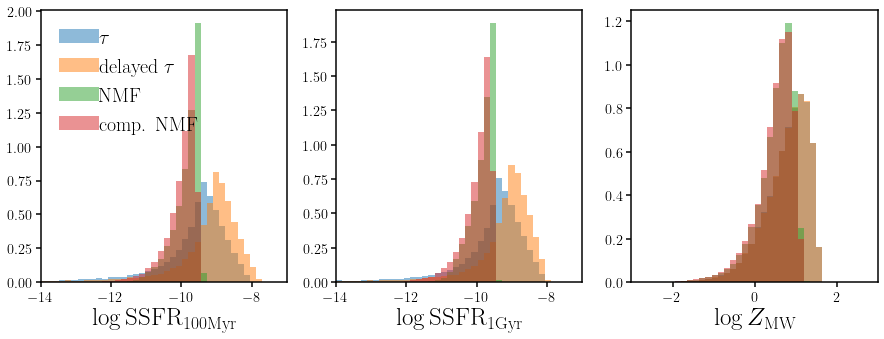

In [11]:
model_labels = [r'$\tau$', r'delayed $\tau$', 'NMF', 'comp. NMF']

props = [SSFRs_100myr, SSFRs_1gyr, Zmws]
lbls = [r'$\log {\rm SSFR}_{\rm 100 Myr}$', r'$\log {\rm SSFR}_{\rm 1 Gyr}$', r'$\log Z_{\rm MW}$']
rngs = [(-14, -7), (-14, -7), (-3, 3)]

fig = plt.figure(figsize=(15,5))
for i, prop in enumerate(props): 
    sub = fig.add_subplot(1,3,i+1)
    for ii, prop_i in enumerate(prop): 
        sub.hist(np.log10(prop_i), density=True, range=rngs[i], bins=40, alpha=0.5, label=model_labels[ii])
    if i == 0: sub.legend(loc='upper left', handletextpad=0, fontsize=20)
    sub.set_xlabel(lbls[i], fontsize=25)
    sub.set_xlim(rngs[i])

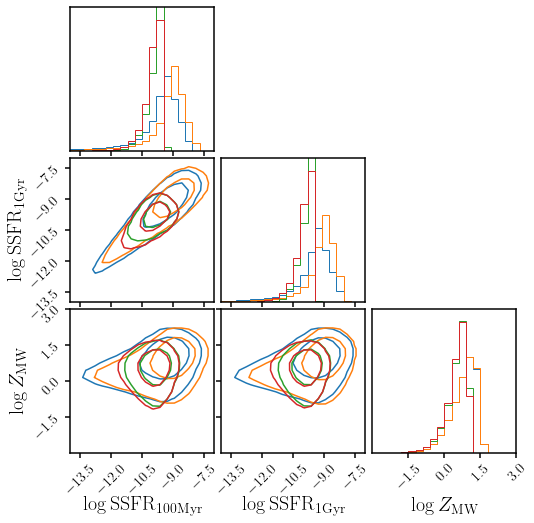

In [12]:
fig = None
for i in range(4): 
    fig = DFM.corner(np.log10(np.array(props)[:,i,:].T), 
                     levels=[0.68, 0.95],
                     smooth=True, 
                     color='C%i' % i, 
                     range=rngs, 
                     labels=lbls,
                     label_kwargs={'fontsize': 20}, 
                     fig=fig, 
                     plot_datapoints=False, fill_contours=False, plot_density=False
                    )

Overall the NMF and compressed NMF models impose more restrictive priors on $\log {\rm SSFR}$ and $\log Z_{\rm MW}$

# redshift dependence of model priors

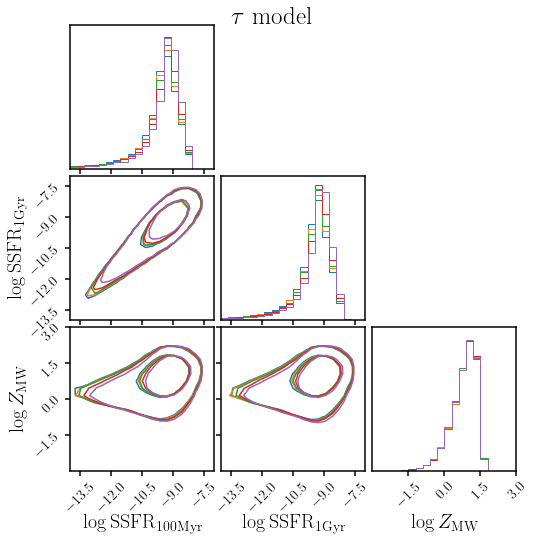

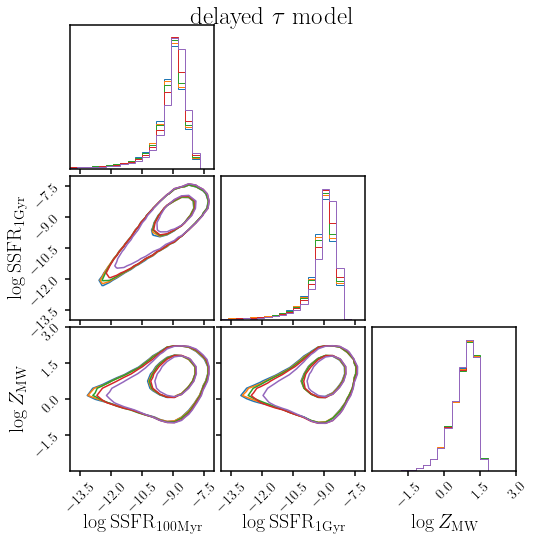

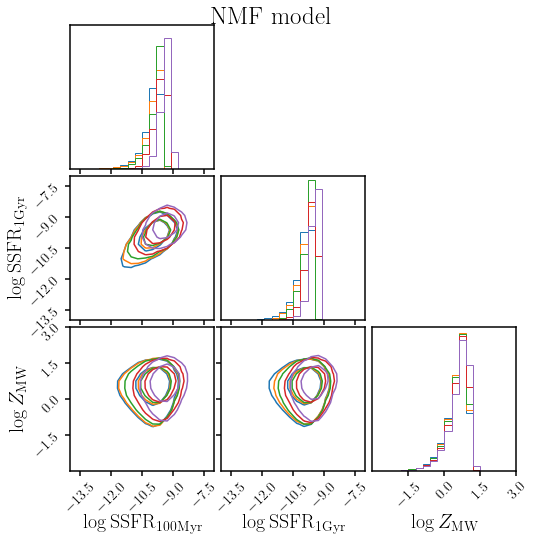

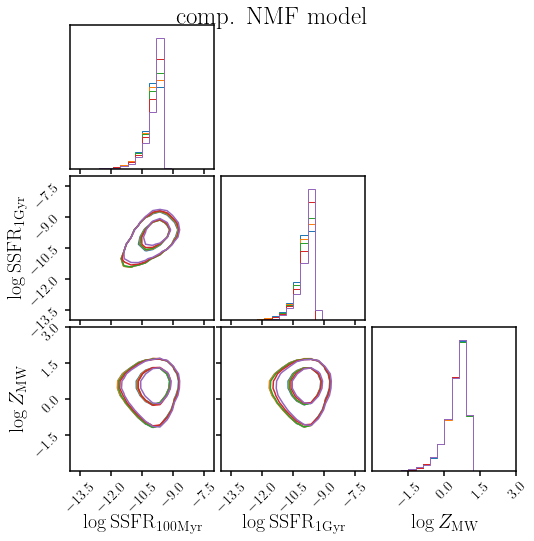

In [13]:
prior_fns = [prior_tau, prior_tau, prior_nmf, prior_nmf]
for model, prior_fn, lbl in zip(models, prior_fns, model_labels):
    
    fig = None
    for i_z, zred in enumerate([0.01, 0.05, 0.1, 0.2, 0.4]): 
        tage = Planck13.age(zred).value
        prior = prior_fn(tage)
    
        thetas = np.array([prior.sample() for i in range(n_sample)])

        _ssfr_100myr = model.avgSFR(thetas, zred, dt=0.1)
        _ssfr_1gyr = model.avgSFR(thetas, zred, dt=1.)    
        _zmw = model.Z_MW(thetas, zred)

        fig = DFM.corner(np.log10(np.array([_ssfr_100myr, _ssfr_1gyr, _zmw])).T, 
                         levels=[0.68, 0.95],
                         smooth=True, 
                         range=rngs, 
                         labels=lbls,
                         label_kwargs={'fontsize': 20}, 
                         color='C%i' % i_z, 
                         fig=fig,
                         plot_datapoints=False, fill_contours=False, plot_density=False
                        )
    fig.suptitle(lbl+' model', fontsize=25)

NMF basis model has significant redshift dependence, but others do not.